In [1]:
%matplotlib widget
from scipy.spatial.distance import squareform
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import set_link_color_palette

import json
from itertools import product
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from afd.tree import TumorTree, precompute_all
from afd.utils import newick_to_tree
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.metrics import silhouette_score

from utils import save_fig_safe

import plotly.io as pio
pio.renderers.default = "notebook"

with open("aml-results-all.json", mode="r") as f:
    data_json = json.load(f)

## Silouhette by number of cluster

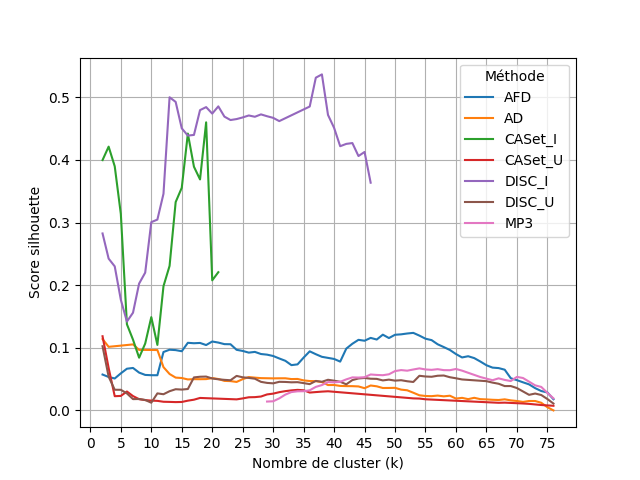

Maximal Values :
	AFD : k=53, silhouette=0.124
	AD : k=2, silhouette=0.114
	CASet_I : k=19, silhouette=0.46
	CASet_U : k=2, silhouette=0.119
	DISC_I : k=38, silhouette=0.537
	DISC_U : k=2, silhouette=0.103
	MP3 : k=54, silhouette=0.067


In [2]:
toplot = ["AFD", "AD", "CASet_I", "CASet_U", "DISC_I", "DISC_U", "MP3"]

cluster_data = [{"k": d["k"], "sscore": d["sscore"], "metric": m} for m in toplot for d in data_json[m]["clusters"]]
cluster_df = pd.DataFrame(cluster_data)
cluster_df["Méthode"] = cluster_df["metric"]

sns.lineplot(data=cluster_df, x="k", y="sscore", hue="Méthode")
plt.xticks(list(range(0, cluster_df["k"].max(), 5)))
plt.xlabel("Nombre de cluster (k)")
plt.ylabel("Score silhouette")
plt.grid(True)
plt.savefig("silouhette_plot_all.pdf")
plt.show()

print("Maximal Values :")
for m in toplot:
    metric_df = cluster_df[cluster_df["metric"] == m]
    max_s = metric_df["sscore"].max()
    k = metric_df[metric_df["sscore"] == max_s]["k"].values[0]
    print(f"\t{m} : k={k}, silhouette={round(max_s, 3)}")

## Dispersion

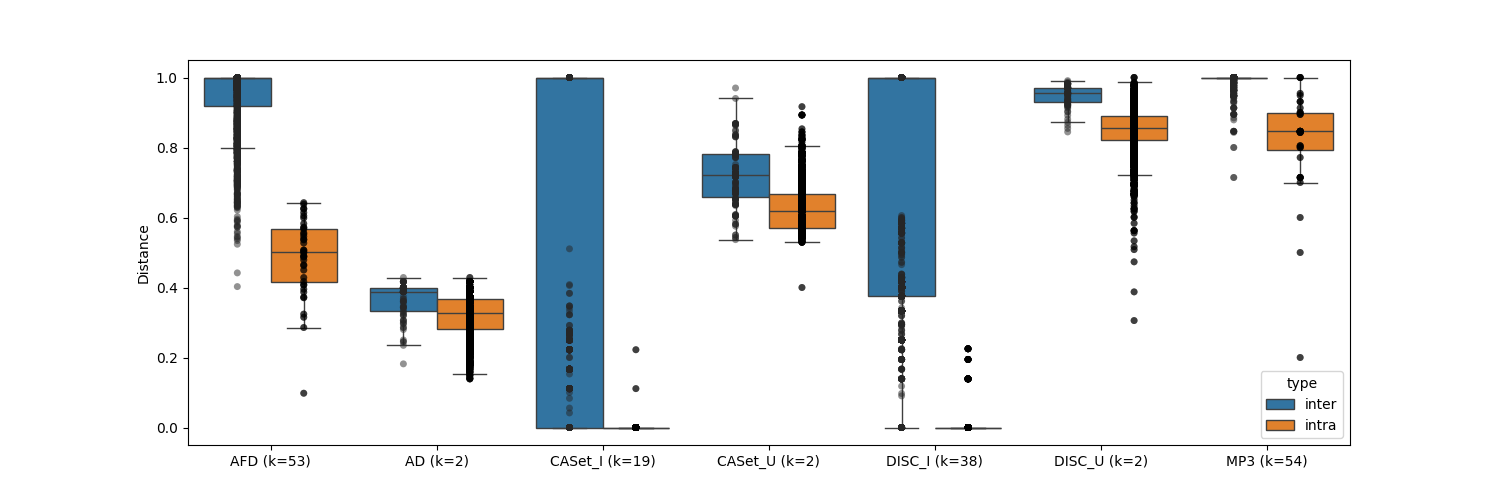

In [3]:
toplot = [("AFD", 53), ("AD", 2), ("CASet_I", 19), ("CASet_U", 2), ("DISC_I", 38), ("DISC_U", 2), ("MP3", 54)]

dispersion_data = [{"metric": f"{m[0]} (k={m[1]})", "type": t, "distance": d} for m in toplot for t in ["inter", "intra"] for d in next(clustering[t] for clustering in data_json[m[0]]["clusters"] if clustering["k"] == m[1])] 
dispersion_df = pd.DataFrame(dispersion_data)

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=dispersion_df, x="metric", y="distance", hue="type", dodge=True, showfliers=False)
#sns.violinplot(data=dispersion_df, x="metric", y="distance", hue="type", dodge=True, density_norm="area")
sns.stripplot(data=dispersion_df, x="metric", y="distance", hue="type", dodge=True, jitter=False, alpha=0.5, palette='dark:black', marker='o')

handles, labels = plt.gca().get_legend_handles_labels()
n = len(set(dispersion_df['type']))
plt.legend(handles[:n], labels[:n], title='type')
plt.ylabel("Distance")
plt.xlabel("")
plt.savefig("dipersion_all.pdf")
plt.show()

## Distance Matrix

In [4]:
def plot_cmap(m, k):    
    dist_matrix = np.array(data_json[m]["dist"])
    condensed_dist = squareform(dist_matrix)
    linkage_matrix = linkage(condensed_dist, method="average")
    labels = [l[4:6] for l in data_json["labels"]]
    cluster_assignments = next(d["tags"] for d in data_json[m]["clusters"] if d["k"] == k)
    
    # Create color mapping for clusters
    unique_clusters = list(set(cluster_assignments))
    n_clusters = len(unique_clusters)
    
    # Count cluster sizes to identify singletons
    cluster_counts = {cluster: cluster_assignments.count(cluster) for cluster in unique_clusters}
    
    # Get only non-singleton clusters for color assignment
    non_singleton_clusters = [cluster for cluster in unique_clusters if cluster_counts[cluster] > 1]
    n_non_singletons = len(non_singleton_clusters)
    
    # Generate colors using the maximum available colors (20 for tab20)
    # Use more colormap cycles if needed
    if n_non_singletons <= 20:
        colors = plt.cm.tab20(np.linspace(0, 1, 20))
    else:
        # Combine multiple colormaps for more colors
        colors1 = plt.cm.tab20(np.linspace(0, 1, 20))
        colors2 = plt.cm.Set3(np.linspace(0, 1, 12))
        colors = np.vstack([colors1, colors2])
    
    cluster_colors = {}
    
    # Assign colors to non-singleton clusters first
    for i, cluster in enumerate(sorted(non_singleton_clusters)):
        rgb = colors[i % len(colors)][:3]
        color_hex = '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
        cluster_colors[cluster] = color_hex
    
    # Assign black to singletons
    for cluster in unique_clusters:
        if cluster_counts[cluster] == 1:
            cluster_colors[cluster] = 'black'
    
    # Create label colors based on cluster assignment
    label_colors = [cluster_colors[cluster] for cluster in cluster_assignments]
    
    # Get the dendrogram ordering from linkage matrix
    dendro = dendrogram(linkage_matrix, no_plot=True)
    ordered_indices = dendro['leaves']
    
    # Reorder distance matrix according to hierarchical clustering
    ordered_dist_matrix = dist_matrix[np.ix_(ordered_indices, ordered_indices)]
    ordered_labels = [labels[i] for i in ordered_indices]
    ordered_label_colors = [label_colors[i] for i in ordered_indices]
    
    fig, ax = plt.subplots(figsize=(10, 10))

    sns.heatmap(
        ordered_dist_matrix,
        xticklabels=ordered_labels,
        yticklabels=ordered_labels,
        cmap='Reds_r',
        #vmin=0,
        #vmax=1,
        cbar=True,
        linewidths=0,
        ax=ax
    )
    
    # Color the tick labels
    for i, (tick_label, color) in enumerate(zip(ax.get_xticklabels(), ordered_label_colors)):
        tick_label.set_fontsize(8)
        tick_label.set_color(color)
    
    for i, (tick_label, color) in enumerate(zip(ax.get_yticklabels(), ordered_label_colors)):
        tick_label.set_fontsize(8)
        tick_label.set_color(color)
    
    plt.title(f'{m} (k={k}, silhouette={round(cluster_df[(cluster_df["k"] == k) & (cluster_df["metric"] == m)]["sscore"].values[0], 2)})', fontsize=14)

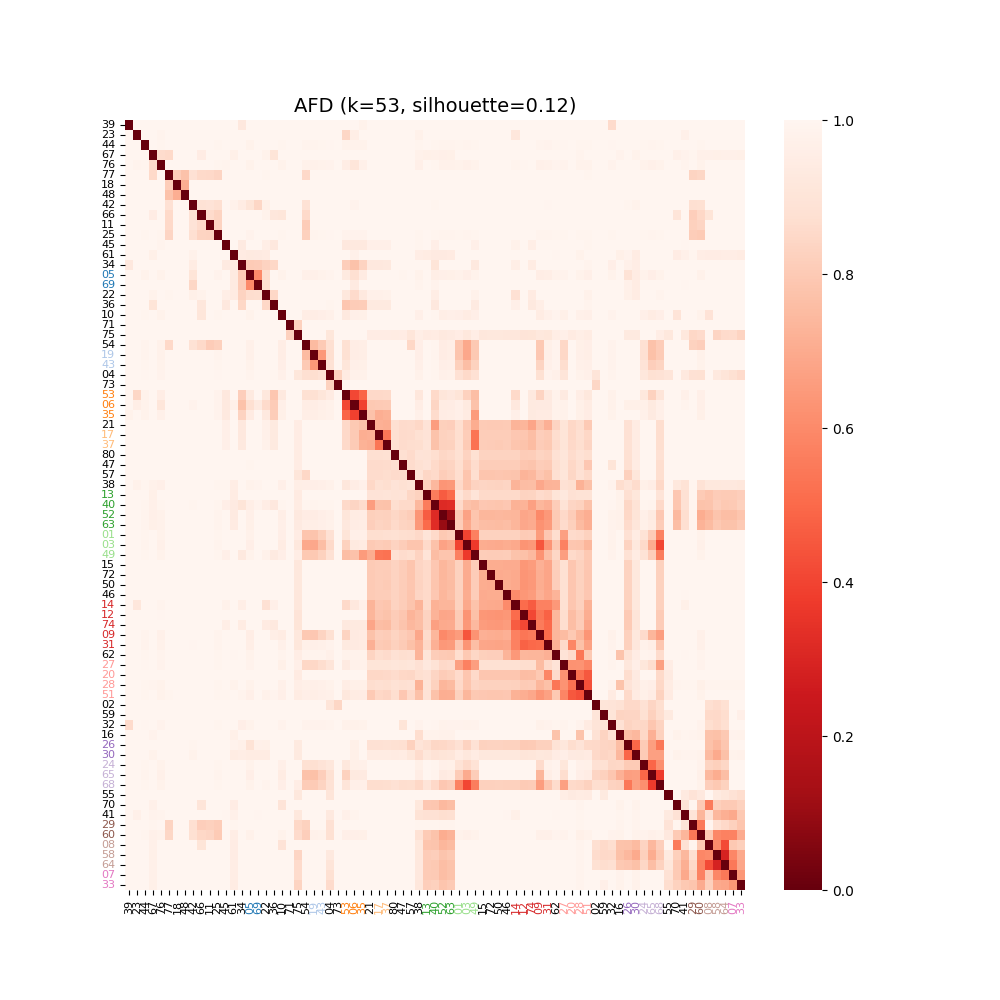

In [5]:
plot_cmap("AFD", 53)
plt.show()

## Dendogram

In [6]:
def plot_dendo(m, k, perc):    
    dist_matrix = np.array(data_json[m]["dist"])
    condensed_dist = squareform(dist_matrix)
    linkage_matrix = linkage(condensed_dist, method="average")
    labels = [l[4:6] for l in data_json["labels"]]
    cluster_assignments = next(d["tags"] for d in data_json[m]["clusters"] if d["k"] == k)
    
    # Create color mapping for clusters
    unique_clusters = list(set(cluster_assignments))
    n_clusters = len(unique_clusters)
    
    # Count cluster sizes to identify singletons
    cluster_counts = {cluster: cluster_assignments.count(cluster) for cluster in unique_clusters}
    
    # Get only non-singleton clusters for color assignment
    non_singleton_clusters = [cluster for cluster in unique_clusters if cluster_counts[cluster] > 1]
    n_non_singletons = len(non_singleton_clusters)
    
    # Generate colors using the maximum available colors (20 for tab20)
    # Use more colormap cycles if needed
    if n_non_singletons <= 20:
        colors = plt.cm.tab20(np.linspace(0, 1, 20))
    else:
        # Combine multiple colormaps for more colors
        colors1 = plt.cm.tab20(np.linspace(0, 1, 20))
        colors2 = plt.cm.Set3(np.linspace(0, 1, 12))
        colors = np.vstack([colors1, colors2])
    
    cluster_colors = {}
    
    # Assign colors to non-singleton clusters first
    for i, cluster in enumerate(sorted(non_singleton_clusters)):
        rgb = colors[i % len(colors)][:3]
        color_hex = '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
        cluster_colors[cluster] = color_hex
    
    # Assign black to singletons
    for cluster in unique_clusters:
        if cluster_counts[cluster] == 1:
            cluster_colors[cluster] = 'black'
    
    # Create label colors based on cluster assignment
    label_colors = [cluster_colors[cluster] for cluster in cluster_assignments]
    
    plt.figure(figsize=(15, 8))
    
    # Set up color palette for scipy dendrogram
    
    # Create a palette with your cluster colors in the SAME ORDER as sorted non-singletons
    palette_colors = []
    
    for cluster in sorted(non_singleton_clusters):
        palette_colors.append(cluster_colors[cluster])
    
    # Set the color palette
    set_link_color_palette(palette_colors)
    
    # Calculate a good threshold to get colored branches
    distances = linkage_matrix[:, 2]
    threshold = np.percentile(distances, perc)  # Adjust this value (60-90) to get good coloring
    
    dend = dendrogram(
        linkage_matrix,
        labels=labels,
        leaf_rotation=45,
        leaf_font_size=10,
        color_threshold=threshold,
        above_threshold_color='black'
    )

    # The dendrogram reorders leaves - get the actual order
    leaf_order = dend['leaves']
    
    # Color the labels based on the reordered positions
    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for i, lbl in enumerate(xlbls):
        # Get the original index from the reordered leaves
        original_idx = leaf_order[i]
        # Color based on original cluster assignment
        lbl.set_color(label_colors[original_idx])
        lbl.set_weight('bold')
    
    plt.title(f'{m} (k={k})', fontsize=14)
    plt.xlabel('Patients AML-xx-001 (arbre de tumeur)', fontsize=12)
    #plt.xlabel('', fontsize=12)
    plt.ylabel(f'Distance', fontsize=12)
    
    # Create legend for cluster colors
    legend_elements = []
    for cluster in sorted(non_singleton_clusters):
        legend_elements.append(
            mpatches.Patch(color=cluster_colors[cluster], label=f'Cluster {cluster}')
        )
    
    # Add singleton legend
    if any(count == 1 for count in cluster_counts.values()):
        legend_elements.append(
            mpatches.Patch(color='black', label='Singletons')
        )

    
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"ddg_{m}_{k}.pdf")
    plt.show()

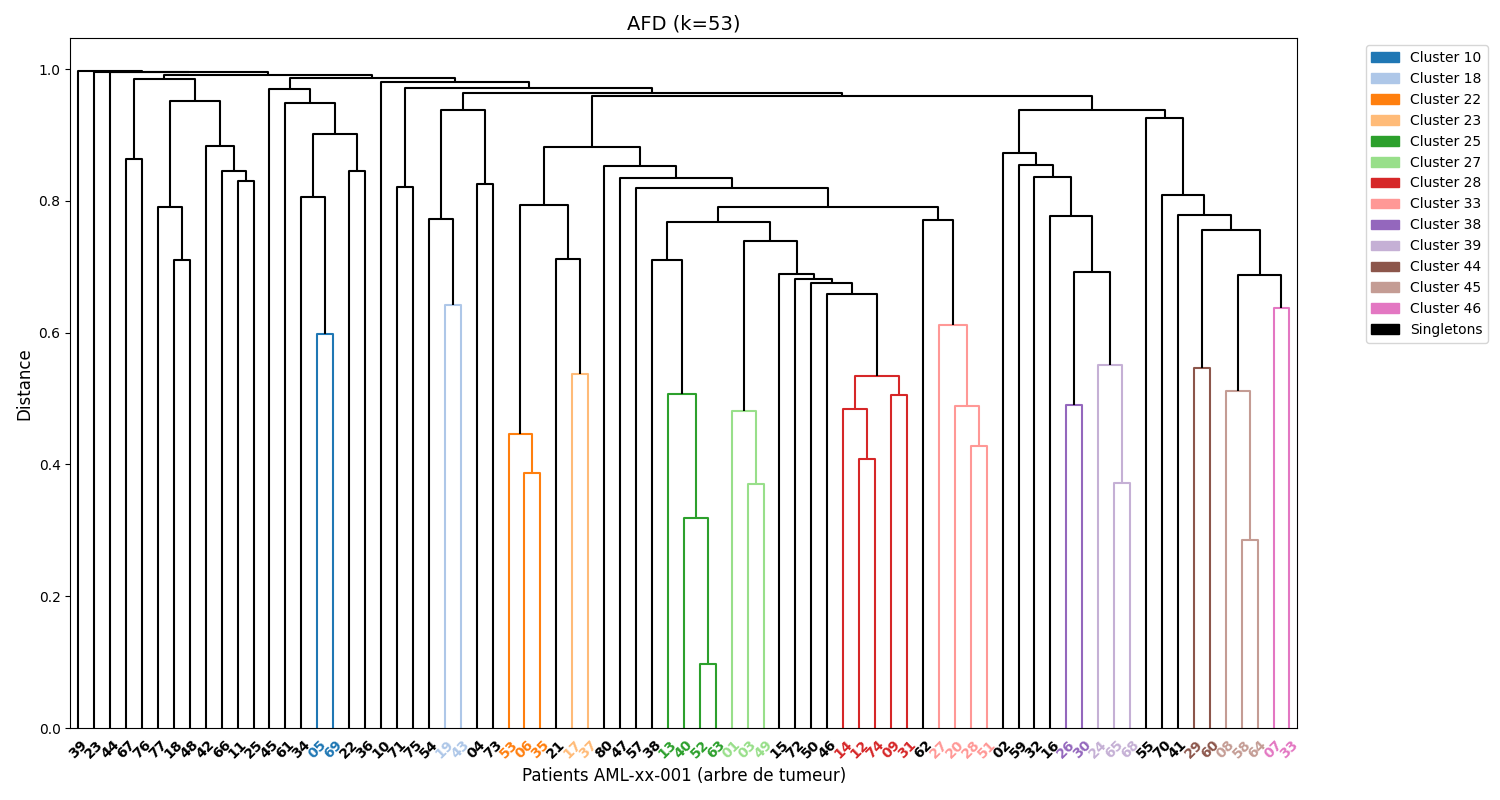

In [7]:
plot_dendo("AFD", 53, 31)

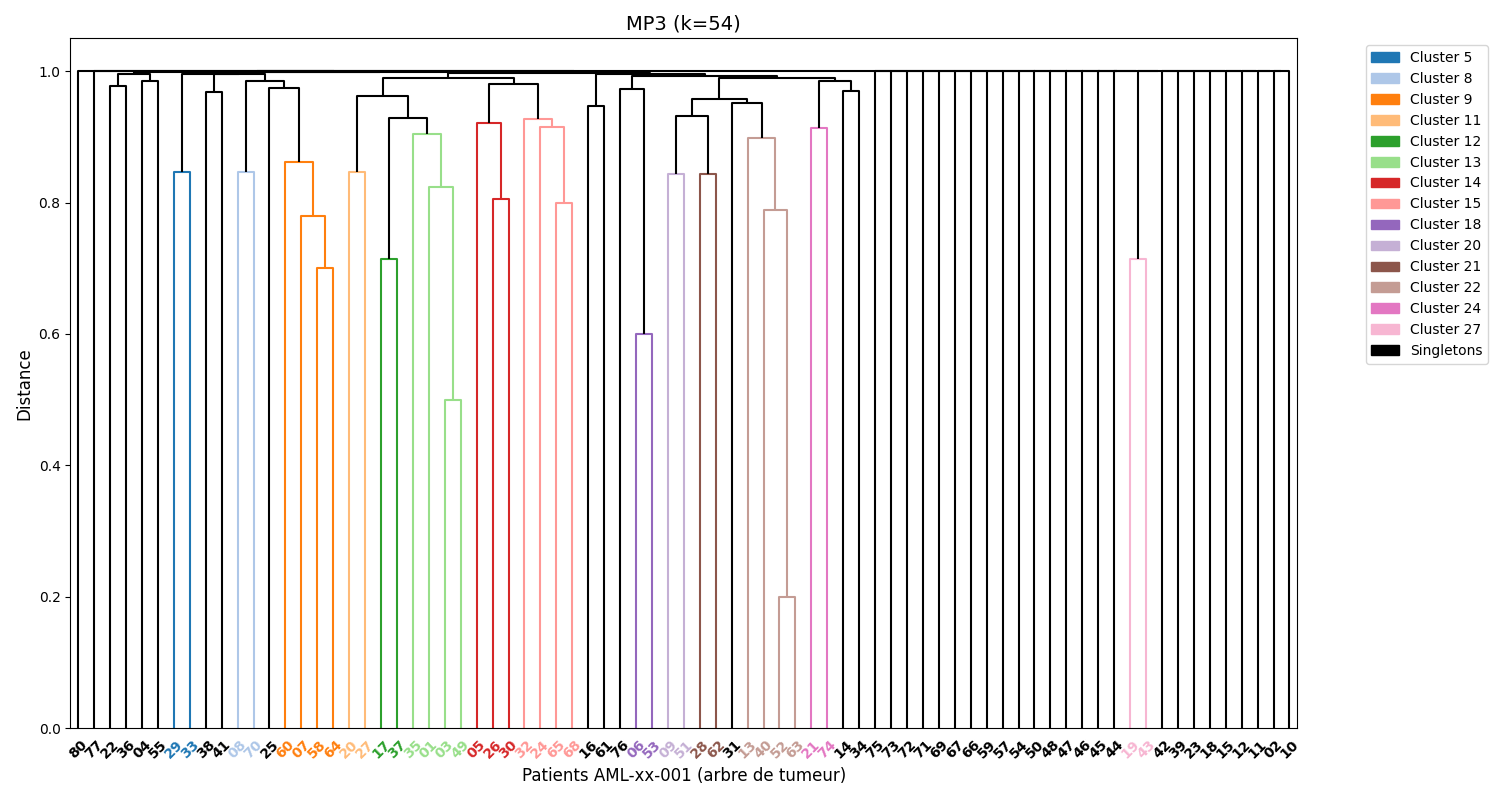

In [8]:
plot_dendo("MP3", 54, 30)